<a href="https://colab.research.google.com/github/LevPerla/Deep_Learning_school/blob/master/homeworks_2/Neural%20Style%20Transfer/HW_NST_pix2pix_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Перла Л.А.
stepik_id = 101366455  
github = https://github.com/LevPerla/Deep_Learning_school/blob/master/homeworks_2/Neural%20Style%20Transfer/HW_NST_pix2pix_CycleGAN.ipynb


Сделано на основе статьи http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Функции и классы

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [ ]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
from torchvision.utils import save_image
def imsave(image):
    unloader = transforms.ToPILImage() # тензор в кратинку  
    image = image.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    save_image(image, 'img1.png')

In [ ]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage() # тензор в кратинку  
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [ ]:
def chanel_interpolate(input, n_chanels, hight, width):
  batch_size , h, w, f_map_num = input.size()
  x = F.interpolate(input, [hight, width])
  x = x.permute(0, 2, 1, 3)
  out = F.interpolate(x, [n_chanels, width], mode='bilinear')
  out = out.permute(0, 2, 1, 3)
  return out

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature_1, target_feature_2=None, mask=None):
            super(StyleLoss, self).__init__()
          
            if mask is not None:
              # находим маски
              mask_1 = ((mask > 0.5) * 1).type(torch.FloatTensor).unsqueeze(0)
              mask_2 = ((mask <= 0.5) * 1).type(torch.FloatTensor).unsqueeze(0)
              
              self.mask_1 = mask_1
              self.mask_2 = mask_2
              self.target_feature_2 = target_feature_2

              mask_1 = chanel_interpolate(mask_1, target_feature_1.shape[1],
                                        target_feature_1.shape[2],
                                        target_feature_1.shape[3])
              target_feature_1 = torch.mul(target_feature_1, mask_1)
              self.target_1 = gram_matrix(target_feature_1)

              if target_feature_2 is not None:
                mask_2 = chanel_interpolate(mask_2, target_feature_1.shape[1],
                                        target_feature_1.shape[2],
                                        target_feature_1.shape[3])
                target_feature_2 = torch.mul(target_feature_2, mask_2)
                self.target_2 = gram_matrix(target_feature_2)

            self.loss = F.mse_loss(self.target_1, self.target_1) + F.mse_loss(self.target_2, self.target_2)

        def forward(self, input):
          if self.mask_1 is not None:
              mask_1 = chanel_interpolate(self.mask_1,
                                          input.shape[1],
                                          input.shape[2],
                                          input.shape[3])
              masked_input_1 = torch.mul(input, mask_1)
              G_1 = gram_matrix(masked_input_1)

              if self.target_feature_2 is not None:
                mask_2 = chanel_interpolate(self.mask_2,
                                            input.shape[1],
                                            input.shape[2],
                                            input.shape[3])
                masked_input_2 = torch.mul(input, mask_2)
                G_2 = gram_matrix(masked_input_2)

          self.loss = F.mse_loss(G_1, self.target_1) + F.mse_loss(G_2, self.target_2)
          return input

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   mask_img=None, style_img2=None,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature_1 = model(style_img).detach()
                if style_img2 is not None:
                  target_feature_2 = model(style_img2).detach()
                else:
                  target_feature_2 = None
                style_loss = StyleLoss(target_feature_1, target_feature_2, mask_img)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break
            model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
def run_style_transfer(cnn,
                       normalization_mean,
                       normalization_std,
                       content_img,
                       style_img,
                       input_img,
                       mask_img=None,
                       style_img2=None,
                       num_steps=500,
                       style_weight=100000,
                       content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean,
            normalization_std,
            style_img,
            content_img,
            mask_img=mask_img,
            style_img2=style_img2)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                    plt.figure()
                    imshow(input_img, title='Output Image')
                    plt.ioff()
                    plt.show()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

## Main

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
imsize = 256

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
style_img = image_loader("munk.jpg")
style_img2 = image_loader("van.jpg")
content_img = image_loader("lev.jpg")

In [ ]:
# Получим маску с помощью detection NN
detector_model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
detector_model.eval()
predictions = detector_model(content_img)
mask_img = predictions[0]["masks"][0]

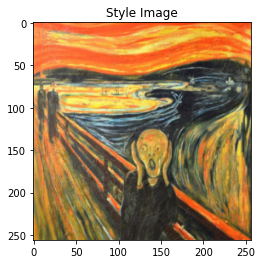

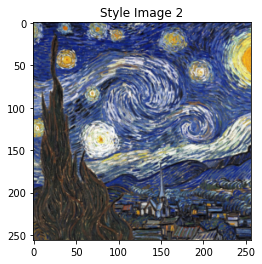

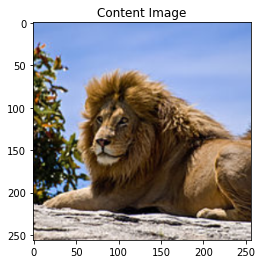

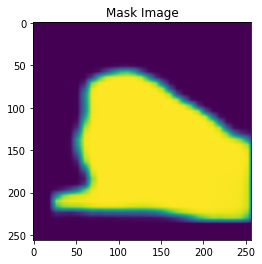

In [ ]:
# отрисовка
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(mask_img, title='Mask Image')

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

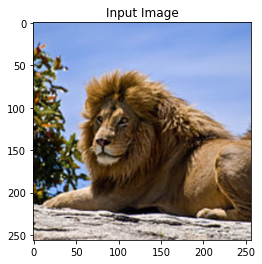

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Optimizing..
run [50]:
Style Loss : 11.522714 Content Loss: 14.631192



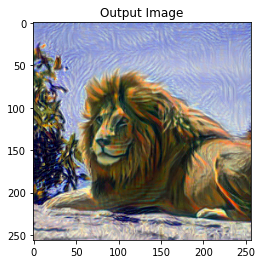

run [100]:
Style Loss : 5.663868 Content Loss: 13.305048



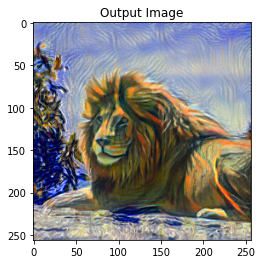

run [150]:
Style Loss : 3.874029 Content Loss: 12.482232



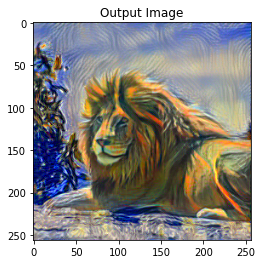

run [200]:
Style Loss : 3.098340 Content Loss: 11.923069



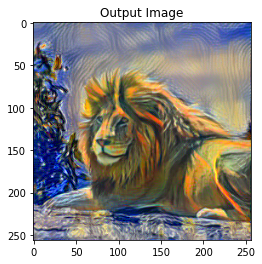

run [250]:
Style Loss : 2.647055 Content Loss: 11.685213



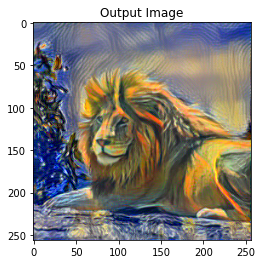

run [300]:
Style Loss : 2.431364 Content Loss: 11.470629



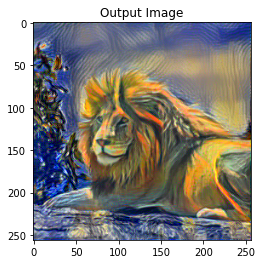

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn,
                            cnn_normalization_mean,
                            cnn_normalization_std,
                            content_img,
                            style_img,
                            input_img,
                            mask_img=mask_img,
                            style_img2=style_img2,
                            num_steps=300)

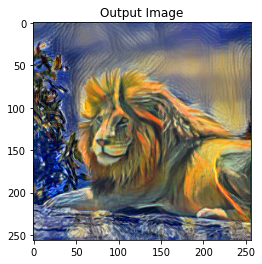

In [ ]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [ ]:
imsave(output)